# Trivial Relations

In this notebook, we investigate if the presence of different edge types between a given gene-disease pair can affect the results.

## Setup

We now load the required packages, load and preprocess the Hetionet and finally load the pretrained model. Please see the `target_prediction` notebook for a more in-depth explanation of these steps.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet

from src.utils import get_predictions_tail

sns.set_theme(style="darkgrid", palette="muted", font_scale=1.5)

In [2]:
data = Hetionet(random_state=42)
df = pd.read_csv(
    "~/.data/pykeen/datasets/hetionet/hetionet-v1.0-edges.sif.gz", sep="\t"
)
G = nx.from_pandas_edgelist(df, "source", "target", create_using=nx.MultiGraph())
degs = dict(G.degree())

In [3]:
# Load the completed model
model = torch.load(
    "./artifacts/transe_hetnet.pkl",
    map_location=torch.device("cpu"),
)

In [4]:
melanoma: str = "Disease::DOID:1909"
parkinsons: str = "Disease::DOID:14330"
fuchs_endothelial_dstrophy: str = "Disease::DOID:11555"
fallopian_tube_cancer: str = "Disease::DOID:1964"

query_relation: str = "DaG"

In [5]:
predictions_df = get_predictions_tail(melanoma, query_relation, data, model, degs)
predictions_df.head()

,tail_id,tail_label,score,in_training,in_testing,entity_type,triple_type,deg
23021,23021,Gene::3569,-2.389650,True,False,Gene,train,774
29634,29634,Gene::7040,-2.431028,False,False,Gene,novel,1188
23818,23818,Gene::3952,-2.485554,False,False,Gene,novel,572
23052,23052,Gene::3600,-2.506621,True,False,Gene,train,389
22188,22188,Gene::301,-2.515852,False,False,Gene,novel,681


## Other Gene-Disease Links

In the Hetionet schema, apart from Gene->associates->Disease, there are two other possible edge types between genes and disease:  Gene->upregulates->Disease (DuG) and Gene->downregulates->Disease (DdG). Here we compute and identify which genes also have either an DuG or DdG edge with the disease of interest.

In [6]:
def compute_gene_disease_links(
    predictions_df: pd.DataFrame, df: pd.DataFrame, disease: str
) -> pd.DataFrame:

    gene_set = set(
        df[
            ((df.metaedge == "DuG") | (df.metaedge == "DdG")) & (df.source == disease)
        ].target.values
    )
    predictions_df["gd"] = [
        "True" if i in gene_set else "False" for i in predictions_df.tail_label.values
    ]

    return predictions_df

In [7]:
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
predictions_df = compute_gene_disease_links(predictions_df, df, melanoma)

In [8]:
def plot_score_degree_gene(df: pd.DataFrame, disease: str) -> None:

    ax = sns.lmplot(
        data=df,
        x="deg",
        y="score",
        hue="gd",
        palette="husl",
        logx=True,
        n_boot=10000,
        seed=0,
        height=6,
        aspect=1.2,
    )
    ax.set(
        xscale="log",
        xlabel="Degree (log)",
        ylabel="Predicted Score",
        xlim=(0.5, 11000),
        title=f"Disease Connection: {disease}",
    )
    ax.legend.set_title("Disease Connection")
    ax.legend.set_bbox_to_anchor((0.8, 0.3))
    plt.show()

We can now plot the association between gene degree and predicted disease association for Melanoma. We can then colour each gene by whether the gene has a DuG or DdG edge to the disease of interest. We can see there is no clear correlation and it seems that gene being linked to the disease by another relationship type doesn't affect the score.

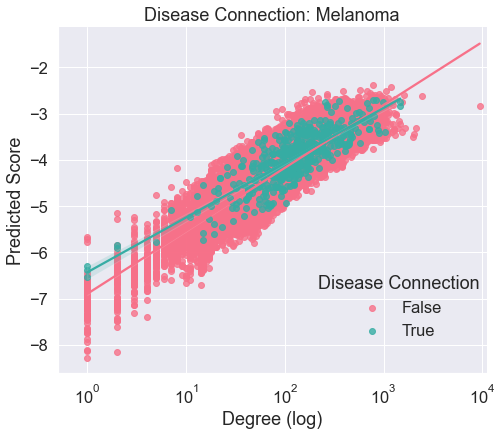

In [9]:
plot_score_degree_gene(predictions_df, "Melanoma")

We can see this relationship also holds for Parkinson's as well.

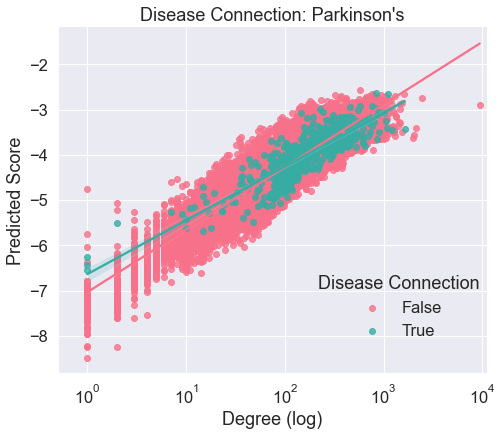

In [10]:
predictions_df = get_predictions_tail(parkinsons, query_relation, data, model, degs)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
predictions_df = compute_gene_disease_links(predictions_df, df, parkinsons)
plot_score_degree_gene(predictions_df, "Parkinson's")